In [2]:
from main_sbm import SBM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import pickle as pkl
from collections import Counter
from eval import retrieve_samples
from igraph.clustering import compare_communities

def generate_graph_bicluster(Sr, Sc, thetas, random_seed = None, edge = "binary", undirected = False):
    # Kr = thetas.shape[0]
    # Kc = thetas.shape[1]

    N = np.sum(Sr)

    Hr = []
    c = 0
    for i in Sr:
        for j in range(i):
            Hr += [c]
        c+=1

    Hc = []
    c = 0
    for i in Sc:
        for j in range(i):
            Hc += [c]
        c+=1

    if isinstance(random_seed, int):
        np.random.seed(random_seed)

    X = np.zeros((N,N))
    if edge == "binary":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.binomial(1, thetas[Hr[i], Hc[j]])
    elif edge == "weighted":
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                X[i, j] = np.random.poisson(thetas[Hr[i], Hc[j]], 1)

    if undirected:
        X = np.triu(X) + np.triu(X).T

    return X

def cluster_summs(Z, ret = False):
    temp_Z = []
    mean_lenght = 0
    mean_nodes = 0
    for i in range(len(Z)):
        current_z = np.sum(Z[i], 0)
        temp_Z.append(current_z)
        mean_lenght += len(current_z)
        mean_nodes += np.mean(current_z)

    mean_lenght /= len(Z)
    mean_nodes /= len(Z)

    print('mean number of clusters', mean_lenght)
    print('mean nodes per cluster', mean_nodes)
    if ret:
        return temp_Z

In [3]:
def compute_VIs(C):
    N = len(C)
    VIs = np.zeros((N,N))

    for i in range(N):
        for j in range(i):
            VIs[i,j] = compare_communities(C[i], C[j])

    VIs += VIs.T

    return VIs

def compute_edge_quantities(X, zr, zc = None, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1 = zr.T @ X @ zr
        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zr


    if mode == 'biclustering':
        M1 = zr.T @ X @ zc

        X = X.copy().astype(int)
        X_rev = (np.where((X==0)|(X==1), X^1, X) - np.eye(X.shape[0])).copy() #reverse matrix for non_links
        M0 = zr.T @ X_rev @ zc

    return M1, M0

def compute_logL(X, zr, zc = None, a=1, b=1, mode = 'biclustering'):
    if mode == 'uniclustering':
        M1, M0 = compute_edge_quantities(X, zr, mode = 'uniclustering')
        

    if mode == 'biclustering':
        M1, M0 = compute_edge_quantities(X, zr, zc, mode = 'biclustering')
    
    logLlhood = np.sum(betaln(M1 + a, M0 + b) - betaln(a, b))
    return logLlhood

def compute_logLs(X, Z, mode = 'biclustering'):
    if mode == 'uniclustering':
        N = len(Z)
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[i], mode = 'uniclustering')
    if mode == 'biclustering':
        N = len(Z[0])
        logLs = [0]*N
        for i in range(N):
            logLs[i] = compute_logL(X, Z[0][i], Z[1][i], mode = 'biclustering')

    return logLs

def compute_Zhat(X, Z, mode = 'biclustering', weight_llhood = False, ret_VI = False, ret_all = False):
    if mode == 'uniclustering':
        Z = retrieve_samples(Z, gap = 10)

        C = [np.where(x == 1)[1].tolist() for x in Z]

        VI = compute_VIs(C)
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, Z, mode = 'uniclustering')
            VI *= -logLs        

        idx_min = np.argmin(VI) 
        z_hat = Z[idx_min]
        c_hat = np.where(z_hat==1)[1]

    if mode == 'biclustering':
        Zr = retrieve_samples(Z[0], gap = 10)
        Zc = retrieve_samples(Z[1], gap = 10)

        Cr = [np.where(x == 1)[1].tolist() for x in Zr]
        Cc = [np.where(x == 1)[1].tolist() for x in Zc]

        VIr = compute_VIs(Cr)
        VIc = compute_VIs(Cc)

        VI = (VIr + VIc)/2
        VI = VI.sum(0)/VI.shape[0]

        if weight_llhood == True:
            logLs = compute_logLs(X, [Zr, Zc], mode = 'biclustering')
            VI *= -logLs

        idx_min = np.argmin(VI) 
        z_hat = [Zr[idx_min], Zc[idx_min]]
        c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

    if ret_all:
        return [Zr, Zc], VI, idx_min

    if ret_VI:
        return z_hat, VI[idx_min]

    return z_hat

def compute_rhos(X, Z, a=1, b=1, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':    
        A = np.array([np.where(Z[i,:] == 1)[0] for i in range(len(Z))]).flatten()

        if edge_type == 'undirected':
            M1 = Z.T @ X @ Z - np.diag(np.sum(X@Z*Z, 0) / 2) 

            m = np.sum(Z, 0)[np.newaxis]

            M0 = m.T@m - np.diag((m*(m+1) / 2).flatten()) - M1 

        elif edge_type == 'directed':
            M1 = Z.T @ X @ Z

            m = np.sum(Z, 0)[np.newaxis]
            M0 = m.T@m - np.diag(m.flatten()) - M1

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[A[i], A[j]]
                non_links = M0[A[i], A[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)

    elif mode == 'biclustering':
        zr = Z[0]
        zc = Z[1]
        cr = np.where(zr==1)[1]
        cc = np.where(zc==1)[1]

        M1 = zr.T @ X @ zc

        X_ = X.copy().astype(int)
        X_rev = (np.where((X_==0)|(X_==1), X_^1, X_) - np.eye(X_.shape[0])).copy() #reverse matrix for non_links

        M0 = zr.T @ X_rev @ zc

        for i in range(len(X)):
            for j in range(len(X)):
                if i == j:
                    continue
                links = M1[cr[i], cc[j]]
                non_links = M0[cr[i], cc[j]]
                rhos[i,j] += (links + a) / (links + non_links + a + b)
    return rhos

def compute_rho(X, sample, edge_type = 'directed', edge_weight = 'binary', mode = 'normal'):
    rhos = np.zeros((len(X), len(X)))
    if mode == 'normal':
        for i in sample:
            rhos += compute_rhos(X, i, edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample)
    if mode == 'biclustering':
        for i in range(len(sample[0])):
            rhos += compute_rhos(X, [sample[0][i], sample[1][i]], 
                            edge_type = edge_type, edge_weight = edge_weight, mode = mode)
        rhos /= len(sample[0])
    return rhos

def compute_predicted_thetas(Sr, Sc, rho):
    prob_matrix = np.zeros((len(Sr), len(Sc)))

    Sr_ = [0] + list(np.cumsum(Sr))
    Sc_ = [0] + list(np.cumsum(Sc))
    for i in range(len(Sr)):
        for j in range(len(Sc)):
            interaction_matrix = rho[Sr_[i]:Sr_[i+1], Sc_[j]:Sc_[j+1]]
            # if i == j:
            #     if len(interaction_matrix) == 1:
            #         continue
            #     prob_matrix[i,j] += np.sum(interaction_matrix)/(len(interaction_matrix)**2 - len(interaction_matrix))
            # else:
            # prob_matrix[i,j] += np.mean(interaction_matrix)
            prob_matrix[i,j] += np.average(interaction_matrix, weights=(interaction_matrix>0))

    return prob_matrix

In [4]:
n_clust = 5
theta = np.zeros((n_clust,n_clust)) + 0.5
np.fill_diagonal(theta, 2)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=42, edge="weighted") #CASE 1

In [5]:
z0

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])]

In [87]:
theta = np.array([[2, 0.5, 0.5, 2, 0.5],
                  [0.5, 2, 0.5, 0.5, 2],
                  [0.5, 0.5, 2, 0.5, 2],
                  [2, 0.5, 0.5, 2, 2],
                  [0.5, 2, 2, 2, 2]])

Sr = [20, 15, 10, 10, 8]
Sc = [20, 15, 10, 10, 8]
# n_clust = 5
# theta = np.zeros((n_clust,n_clust)) + 0.5
# np.fill_diagonal(theta, 2)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

# Sr = [30, 30, 15, 15, 10]
# Sc = [30, 30, 15, 15, 10]

# Sr = [15, 15, 15, 15]
# Sc = [15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40, edge="weighted") #CASE 2

In [85]:
theta = np.array([[2, 0.5, 2, 2, 0.5],
                  [0.5, 2, 0.5, 0.5, 2],
                  [2, 2, 0.5, 2, 2],
                  [2, 0.5, 0.5, 0.5, 0.5],
                  [2, 0.5, 0.5, 2, 2]])

Sr = [15, 15, 15, 15, 15]
Sc = [15, 15, 15, 15, 15]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40,  edge="weighted") #CASE 3

In [63]:
theta = np.array([[2, 0.5, 0.1, 5, 2],
                  [0.1, 2, 0.1, 0.1, 0.5],
                  [0.1, 2, 0.5, 5, 0.5],
                  [2, 5, 7, 0.5, 2]])

Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40, edge="weighted") #CASE 4

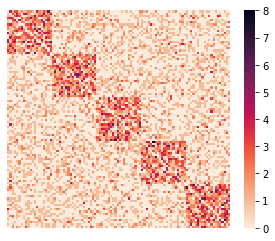

In [100]:
fig, ax = plt.subplots(figsize = (5,4))
ax = sns.heatmap(X, linewidth=0.0, ax = ax, cbar=True, cmap= 'rocket_r', xticklabels=[], yticklabels=[])
plt.show()

In [66]:
config = {'directed': True,
          'binary' : False,
          'unicluster': True}
DP = SBM(config, alpha_PY_r=3, start_z="singleton", set_seed=42)
# DP.fit(X,100)
# print(cluster_summs(DP.Z[90:]))
# Counter(np.argwhere(DP.Z[-1])[:,1])

DP.fit(X, 10000)
with open("results/Case4_DP_w_Z_unipartite.pickle", "wb") as f:
    pkl.dump(DP.Z, f)

print(cluster_summs(DP.Z[len(DP.Z)//2:]))
print(Counter(np.argwhere(DP.Z[-1])[:,1]))

mean number of clusters 8.0
mean nodes per cluster 12.5
None
Counter({0: 20, 7: 20, 2: 15, 5: 15, 3: 10, 4: 10, 1: 5, 6: 5})


In [67]:
DP.fit(X, 1)

In [68]:
# print(cluster_summs(DP.Z[00:600]))
# DP.expected_cl(DP.N, 0, 3.5, np.Infinity)
# list_Z = cluster_summs(DP.Z, ret = True)
# np.quantile([len(x) for x in list_Z], 2)
# np.quantile([len(x) for x in list_Z], 0.5)

In [69]:
config = {'directed': True,
          'binary' : False,
          'unicluster': False}
DP_bi = SBM(config, alpha_PY_r = 3, alpha_PY_c=3,
            start_z = "singleton", set_seed=42)
# DP_bi.fit(X,100)

DP_bi.fit(X, 10000)
with open("results/Case4_DP_w_Z_bipartite.pickle", "wb") as f:
    pkl.dump(DP_bi.Z, f)

print(cluster_summs(DP_bi.Zr[len(DP_bi.Zr)//2:]))
print(cluster_summs(DP_bi.Zc[len(DP_bi.Zc)//2:]))
print(Counter(np.argwhere(DP_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(DP_bi.Zc[-1])[:,1]))

mean number of clusters 4.043
mean nodes per cluster 24.786
None
mean number of clusters 5.0802
mean nodes per cluster 19.73533333333343
None
Counter({0: 25, 3: 25, 1: 25, 2: 25})
Counter({4: 20, 0: 20, 1: 20, 2: 20, 3: 20})


In [70]:
DP_bi.fit(X,1)

In [71]:
config = {'directed': True,
          'binary' : False,
          'unicluster': True}
PY = SBM(config, prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3, 
           start_z = "singleton", set_seed=42)
# PY.fit(X,100)

PY.fit(X, 10000)
with open("results/Case4_PY_w_Z_unipartite.pickle", "wb") as f:
    pkl.dump(PY.Z, f)

print(cluster_summs(PY.Z[len(PY.Z)//2:]))
print(Counter(np.argwhere(PY.Z[-1])[:,1]))

mean number of clusters 8.0
mean nodes per cluster 12.5
None
Counter({0: 20, 7: 20, 2: 15, 5: 15, 3: 10, 4: 10, 1: 5, 6: 5})


In [72]:
PY.fit(X,1)

In [73]:
config = {'directed': True,
          'binary' : False,
          'unicluster': False}
PY_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "PY", alpha_PY_r=0.6,sigma_PY_r=-0.3,
         prior_c = "PY", alpha_PY_c=0.6,sigma_PY_c=-0.3)

# PY_bi.fit(X,500)

PY_bi.fit(X, 10000)
with open("results/Case4_PY_w_Z_bipartite.pickle", "wb") as f:
    pkl.dump(PY_bi.Z, f)

print(cluster_summs(PY_bi.Zr[len(PY_bi.Zr)//2:]))
print(cluster_summs(PY_bi.Zc[len(PY_bi.Zc)//2:]))
print(Counter(np.argwhere(PY_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(PY_bi.Zc[-1])[:,1]))

mean number of clusters 4.0032
mean nodes per cluster 24.984
None
mean number of clusters 5.0084
mean nodes per cluster 19.972
None
Counter({0: 25, 1: 25, 2: 25, 3: 25})
Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})


In [74]:
PY_bi.fit(X,1)

In [75]:
config = {'directed': True,
          'binary' : False,
          'unicluster': True}
DM = SBM(config, prior_r = "DM",beta_DM_r=3.5/50,K_DM_r=50,
            start_z = "singleton", set_seed=42)
# DM.fit(X,100)

DM.fit(X, 10000)
with open("results/Case4_DM_w_Z_unipartite.pickle", "wb") as f:
    pkl.dump(DM.Z, f)

print(cluster_summs(DM.Z[len(DM.Z)//2:]))
print(Counter(np.argwhere(DM.Z[-1])[:,1]))

mean number of clusters 8.0
mean nodes per cluster 12.5
None
Counter({0: 20, 7: 20, 2: 15, 5: 15, 3: 10, 4: 10, 1: 5, 6: 5})


In [76]:
DM.fit(X,1)

In [77]:
config = {'directed': True,
          'binary' : False,
          'unicluster': False}
DM_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "DM", beta_DM_r=3.5/50, K_DM_r=50,
         prior_c = "DM", beta_DM_c=3.5/50, K_DM_c=50)
# DM_bi.fit(X,500)

DM_bi.fit(X, 10000)
with open("results/Case4_DM_w_Z_bipartite.pickle", "wb") as f:
    pkl.dump(DM_bi.Z, f)

print(cluster_summs(DM_bi.Zr[len(DM_bi.Zr)//2:]))
print(cluster_summs(DM_bi.Zc[len(DM_bi.Zc)//2:]))
print(Counter(np.argwhere(DM_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(DM_bi.Zc[-1])[:,1]))

mean number of clusters 4.0536
mean nodes per cluster 24.734
None
mean number of clusters 5.097
mean nodes per cluster 19.68009523809534
None
Counter({0: 25, 3: 25, 1: 25, 2: 25})
Counter({3: 20, 0: 20, 1: 20, 2: 20, 4: 20})


In [78]:
DM_bi.fit(X,1)

In [79]:
config = {'directed': True,
          'binary' : False,
          'unicluster': True}
GN = SBM(config, prior_r = "GN", gamma_GN_r=0.45,
            start_z = "singleton", set_seed=42)
# GN.fit(X,100)

GN.fit(X, 10000)
with open("results/Case4_w_GN_w_Z_unipartite.pickle", "wb") as f:
    pkl.dump(GN.Z, f)

print(cluster_summs(GN.Z[len(GN.Z)//2:]))
print(Counter(np.argwhere(GN.Z[-1])[:,1]))

mean number of clusters 8.0
mean nodes per cluster 12.5
None
Counter({0: 20, 7: 20, 2: 15, 5: 15, 3: 10, 4: 10, 1: 5, 6: 5})


In [80]:
GN.fit(X,1)

In [81]:
config = {'directed': True,
          'binary' : False,
          'unicluster': False}
GN_bi = SBM(config, start_z = "singleton", set_seed=42,
         prior_r = "GN", gamma_GN_r=0.45,
         prior_c = "GN", gamma_GN_c=0.45)
# GN_bi.fit(X,100)

GN_bi.fit(X, 10000)
with open("results/Case4_GN_w_Z_bipartite.pickle", "wb") as f:
    pkl.dump(GN_bi.Z, f)

print(cluster_summs(GN_bi.Zr[len(GN_bi.Zr)//2:]))
print(cluster_summs(GN_bi.Zc[len(GN_bi.Zc)//2:]))
print(Counter(np.argwhere(GN_bi.Zr[-1])[:,1]))
print(Counter(np.argwhere(GN_bi.Zc[-1])[:,1]))

mean number of clusters 4.0
mean nodes per cluster 25.0
None
mean number of clusters 5.0
mean nodes per cluster 20.0
None
Counter({0: 25, 1: 25, 2: 25, 3: 25})
Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20})


In [116]:
m = np.array([80,1])
gamma = 0.45
print(np.append((m + 1) * (np.sum(m) - len(m) + gamma), len(m)**2 - len(m)*gamma))
np.log(np.append((m + 1) * (np.sum(m) - len(m) + gamma), len(m)**2 - len(m)*gamma))

[6.43545e+03 1.58900e+02 3.10000e+00]


array([8.76957705, 5.06827507, 1.13140211])

Analysis

In [107]:
def evalZ(Z, z0):
    Zr = retrieve_samples(Z[0], gap = 10)
    Zc = retrieve_samples(Z[1], gap = 10)

    Cr = [np.where(x == 1)[1].tolist() for x in Zr]
    Cc = [np.where(x == 1)[1].tolist() for x in Zc]

    VIr = 0
    VIc = 0
    for i in range(len(Cr)):
        VIr += compare_communities(Cr[i], z0[0])
        VIc += compare_communities(Cc[i], z0[1])

    VIr = VIr/len(Cr)
    VIc = VIc/len(Cc)

    VI_relative_true = np.mean([VIr, VIc])

    Zsample, VI, idx_min = compute_Zhat(X, Z, mode = 'biclustering', ret_all = True)

    z_hat = [Zsample[0][idx_min], Zsample[1][idx_min]]
    c_hat = [np.where(z_hat[0]==1)[1], np.where(z_hat[1]==1)[1]]

    sorted_VI = VI[np.argsort(VI)]
    sorted_Zr = [Zsample[0][i] for i in np.argsort(VI)]
    sorted_Zc = [Zsample[1][i] for i in np.argsort(VI)]

    b_threshold = int(len(VI)*0.95)

    zr_ball = sorted_Zr[b_threshold]
    zc_ball = sorted_Zc[b_threshold]

    c_ball = [np.where(zr_ball==1)[1], np.where(zc_ball==1)[1]]

    VI_relative_ball = np.mean([compare_communities(c_hat[0], c_ball[0]), 
                                compare_communities(c_hat[1], c_ball[1])])

    VIr_true = compare_communities(c_hat[0], z0[0])
    VIc_true = compare_communities(c_hat[1], z0[1])

    print("VIr: ", VIr_true)
    print("VIc: ", VIc_true)
    print("VI_rel_true: ", VI_relative_true)
    print("VI_rel_ball: ", VI_relative_ball)


    Kr_vector = [i.shape[1] for i in sorted_Zr]
    Kc_vector = [i.shape[1] for i in sorted_Zc] 
    print("Kr")
    print('0.25: ', np.quantile(np.sort(Kr_vector), 0.25))
    print('0.50: ', np.quantile(np.sort(Kr_vector), 0.5))
    print('0.75: ', np.quantile(np.sort(Kr_vector), 0.75))

    print("Kc")
    print('0.25: ', np.quantile(np.sort(Kc_vector), 0.25))
    print('0.50: ', np.quantile(np.sort(Kc_vector), 0.5))
    print('0.75: ', np.quantile(np.sort(Kc_vector), 0.75))

    # rho = compute_rho(X, Zsample, mode = 'biclustering')
    # predicted_thetas = compute_predicted_thetas(Sr, Sc, rho)

    # MAE = np.sum(np.abs(true_rho - rho))/(len(rho)**2 - len(rho))
    # print("MAE: ", MAE)

    

with open("results/Case1_DP_w_Z_unipartite.pickle", "rb") as f:
    DP_w_Z = pkl.load(f)

In [108]:
n_clust = 5
theta = np.zeros((n_clust,n_clust)) + 0.5
np.fill_diagonal(theta, 2)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

Sr = [20, 20, 20, 20, 20]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=42, edge="weighted") #CASE 1

In [110]:
with open("results/Case1_DP_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
with open("results/Case1_PY_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.00020943928669492885
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [112]:
with open("results/Case1_DM_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
# with open("results/Case1_GN_w_Z_unipartite.pickle", "rb") as f:
#     Z_uni = pkl.load(f)
# Z = [Z_uni, Z_uni]
# evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.00020943928669492885
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0




In [113]:
with open("results/Case1_DP_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case1_PY_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.018419935795361872
VI_rel_ball:  0.07221134600831958
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0022187459585551314
VI_rel_ball:  0.019851524334587367
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [114]:
with open("results/Case1_DM_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case1_GN_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.02237438465051845
VI_rel_ball:  0.08093795454007657
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  6.0


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [138]:
theta = np.array([[2, 0.5, 0.5, 2, 0.5],
                  [0.5, 2, 0.5, 0.5, 2],
                  [0.5, 0.5, 2, 0.5, 2],
                  [2, 0.5, 0.5, 2, 2],
                  [0.5, 2, 2, 2, 2]])

Sr = [20, 15, 10, 10, 8]
Sc = [20, 15, 10, 10, 8]
# n_clust = 5
# theta = np.zeros((n_clust,n_clust)) + 0.5
# np.fill_diagonal(theta, 2)

# Sr = [20]*n_clust
# Sc = [20]*n_clust

# Sr = [30, 30, 15, 15, 10]
# Sc = [30, 30, 15, 15, 10]

# Sr = [15, 15, 15, 15]
# Sc = [15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40, edge="weighted") #CASE 2

In [139]:
print("DP: ")
with open("results/Case2_DP_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case2_PY_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0020654283337314537
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0

PY: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.001503207289359085
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [140]:
print("DM: ")
with open("results/Case2_DM_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nGN: ")
# with open("results/Case2_GN_w_Z_unipartite.pickle", "rb") as f:
#     Z_uni = pkl.load(f)
# Z = [Z_uni, Z_uni]
# evalZ(Z, z0)

DM: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0020654283337314537
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0

GN: 


In [119]:
with open("results/Case2_DP_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case2_PY_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.2164494256495182
VIc:  0.0
VI_rel_true:  0.1644499802929198
VI_rel_ball:  0.15686991024086838
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  6.0


VIr:  0.2164494256495182
VIc:  0.0
VI_rel_true:  0.13802124070146227
VI_rel_ball:  0.11541516595280199
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [120]:
with open("results/Case2_DM_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
# with open("results/Case2_GN_w_Z_bipartite.pickle", "rb") as f:
#     Z_uni = pkl.load(f)
# Zr = [x[0] for x in [i for i in Z_uni]]
# Zc = [x[1] for x in [i for i in Z_uni]]    
# Z = [Zr, Zc]
# evalZ(Z, z0)

VIr:  0.2164494256495182
VIc:  0.0
VI_rel_true:  0.17042193373293138
VI_rel_ball:  0.15975211198141048
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  6.0
0.75:  6.0




In [141]:
theta = np.array([[2, 0.5, 2, 2, 0.5],
                  [0.5, 2, 0.5, 0.5, 2],
                  [2, 2, 0.5, 2, 2],
                  [2, 0.5, 0.5, 0.5, 0.5],
                  [2, 0.5, 0.5, 2, 2]])

Sr = [15, 15, 15, 15, 15]
Sc = [15, 15, 15, 15, 15]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40,  edge="weighted") #CASE 3

In [142]:
print("DP: ")
with open("results/Case3_DP_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case3_PY_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.00029813298013313004
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0

PY: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  9.797201071785366e-05
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [143]:
print("DP: ")
with open("results/Case3_DM_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
# with open("results/Case3_GN_w_Z_unipartite.pickle", "rb") as f:
#     Z_uni = pkl.load(f)
# Z = [Z_uni, Z_uni]
# evalZ(Z, z0)

DP: 
VIr:  0.0
VIc:  0.0
VI_rel_true:  0.00029813298013313004
VI_rel_ball:  0.0
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0

PY: 


In [130]:
with open("results/Case3_DP_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case3_PY_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.04898600535892683
VIc:  0.09886155921630513
VI_rel_true:  0.15105857262055908
VI_rel_ball:  0.2499827885629573
Kr
0.25:  5.0
0.50:  5.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  6.0
0.75:  6.0


VIr:  0.0
VIc:  0.09886155921630513
VI_rel_true:  0.10634314176861179
VI_rel_ball:  0.18657875719934802
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [144]:
with open("results/Case3_DM_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case3_GN_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.04898600535892683
VIc:  0.09886155921630513
VI_rel_true:  0.1641646052648196
VI_rel_ball:  0.21602800203223782
Kr
0.25:  5.0
0.50:  6.0
0.75:  6.0
Kc
0.25:  5.0
0.50:  6.0
0.75:  6.0


VIr:  0.0
VIc:  0.09886155921630513
VI_rel_true:  0.09688376741328406
VI_rel_ball:  0.1791198778778107
Kr
0.25:  5.0
0.50:  5.0
0.75:  5.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [145]:
theta = np.array([[2, 0.5, 0.1, 5, 2],
                  [0.1, 2, 0.1, 0.1, 0.5],
                  [0.1, 2, 0.5, 5, 0.5],
                  [2, 5, 7, 0.5, 2]])

Sr = [25, 25, 25, 25]
Sc = [20, 20, 20, 20, 20]

Hr = []
c = 0
for i in Sr:
    for j in range(i):
        Hr += [c]
    c+=1

Hc = []
c = 0
for i in Sc:
    for j in range(i):
        Hc += [c]
    c+=1

z0 = [np.array(Hr), np.array(Hc)]

X = generate_graph_bicluster(Sr, Sc, theta, random_seed=40, edge="weighted") #CASE 4

In [146]:
print("DP: ")
with open("results/Case4_DP_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\nPY: ")
with open("results/Case4_PY_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)

DP: 
VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.47513526961661834
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0

PY: 
VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.47513526961661834
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0


In [134]:
with open("results/Case4_DM_w_Z_unipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Z = [Z_uni, Z_uni]
evalZ(Z, z0)
print("\n")
# with open("results/Case4_GN_w_Z_unipartite.pickle", "rb") as f:
#     Z_uni = pkl.load(f)
# Z = [Z_uni, Z_uni]
# evalZ(Z, z0)

VIr:  0.5867070452737218
VIc:  0.36356349395951204
VI_rel_true:  0.47513526961661834
VI_rel_ball:  0.0
Kr
0.25:  8.0
0.50:  8.0
0.75:  8.0
Kc
0.25:  8.0
0.50:  8.0
0.75:  8.0




In [135]:
with open("results/Case4_DP_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case4_PY_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.005868000933219901
VI_rel_ball:  0.03995315294014756
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0027133712931996794
VI_rel_ball:  0.03995315294014756
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


In [136]:
with open("results/Case4_DM_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)
print("\n")
with open("results/Case4_GN_w_Z_bipartite.pickle", "rb") as f:
    Z_uni = pkl.load(f)
Zr = [x[0] for x in [i for i in Z_uni]]
Zc = [x[1] for x in [i for i in Z_uni]]    
Z = [Zr, Zc]
evalZ(Z, z0)

VIr:  0.0
VIc:  0.0
VI_rel_true:  0.006491728544748696
VI_rel_ball:  0.03995315294014756
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0


VIr:  0.0
VIc:  0.0
VI_rel_true:  0.0022373765646482636
VI_rel_ball:  0.03995315294014756
Kr
0.25:  4.0
0.50:  4.0
0.75:  4.0
Kc
0.25:  5.0
0.50:  5.0
0.75:  5.0
